In [1]:
import warnings
warnings.filterwarnings('ignore')

# 🤗 Datasets

Datasets is a lightweight and extensible library to easily share and access datasets and evaluation metrics for Natural Language Processing (NLP) and more.

In [2]:
from huggingface_hub import list_datasets

all_datasets = list(list_datasets())

print(f"There are {len(all_datasets)} datasets in the hub.")

There are 75293 datasets in the hub.


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotions["train"][:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [8]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

**Loading datasets not on the hub**

1. CSV: `load_dataset('csv', data_files='path/to/file.csv', sep=',', names=['col_1', 'col_2', 'col_3'])`
2. Text: `load_dataset('text', data_files='path/to/file.txt', sep='\n\n')`
3. JSON: `load_dataset('json', data_files='path/to/file.json')`

# From Datasets to DataFrames

In [9]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
df["label_name"] = df["label"].apply(lambda row: emotions["train"].features["label"].int2str(row))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Class distribution

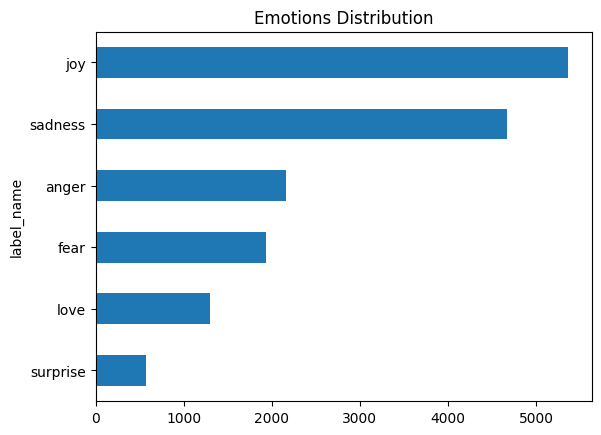

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Emotions Distribution")
plt.show();

## How long are our sentences?

This classification will use **DistilBERT**, a variant of BERT that achieves comparable performance, while being significantly smaller and more efficient. This enables training a classifier in a few minutes. To train a larger BERT model, one can simply change the checkpoint of the pretrained model. A *checkpoint* corresponds to the set of weights that are loaded into a given transformer architecture.

For applications using DistilBERT, the maximum context size is 512 tokens. From the plot we see that for each emotion, most sentences are around 15 words long and the longest are well below DistilBERT's maximum context size.

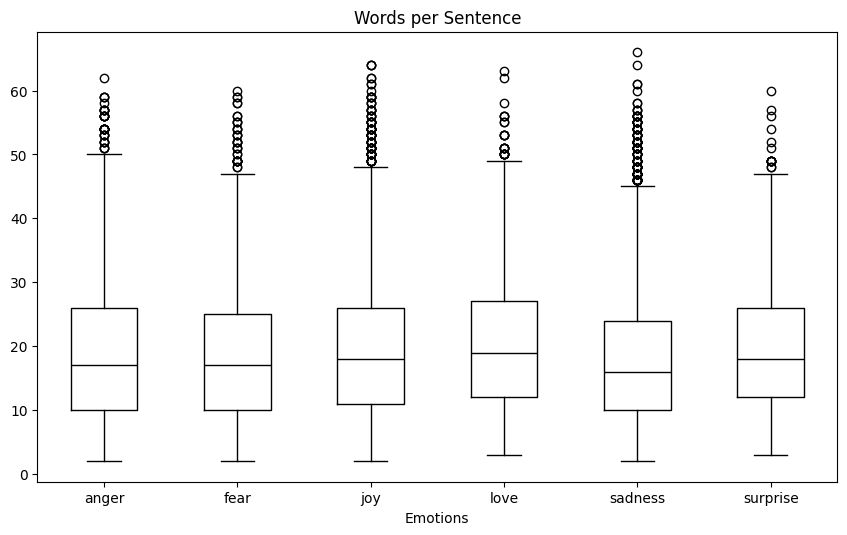

In [27]:
df["words_count"] = df["text"].str.split().apply(len)
df.boxplot(
  column="words_count",
  by="label_name",
  grid=False,
  showfliers=True,
  color="black", 
  figsize=(10, 6)
)
plt.title("Words per Sentence")
plt.suptitle("")
plt.xlabel("Emotions")
plt.show();

In [29]:
emotions.reset_format()

# From text to tokens

BERT and DistilBERT are pretrained models that were trained on subword tokenization using the WordPiece tokenizer algorithm.

🤗 Transformers provides a convenient `AutoTokenizer` class that allows one to quickly load the tokenizer associated with a pretrained model - by just calling its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path.

In [31]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [35]:
tokenizer.vocab_size

30522

In [36]:
# maximum context size
tokenizer.model_max_length

512

In [37]:
# fields the model expects in its forward pass
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [32]:
text = "Tokenizing text is a core task of NLP."

encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [33]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [34]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

## Tokenizing the whole dataset

In [40]:
emotions_encoded = emotions.map(lambda batch: tokenizer(batch["text"], padding=True, truncation=True), batched=True, batch_size=None)
emotions_encoded

Map: 100%|██████████| 2000/2000 [00:00<00:00, 37095.25 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [42]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

## Transformers as feature extractors

### Using pretrained models

In [44]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)


In [46]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
inputs, inputs["input_ids"].shape

({'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])},
 torch.Size([1, 6]))

In [47]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.inference_mode():
  outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)

In [48]:
# tensor shape: [batch_size, n_tokens, hidden_dims]
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

In [49]:
def extract_hidden_states(batch):
  # move inputs to device
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # extract last hidden states
  with torch.inference_mode():
    last_hidden_state = model(**inputs).last_hidden_state

  return { "hidden_state": last_hidden_state[:, 0].cpu().numpy() }

In [50]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [51]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   6%|▋         | 1000/16000 [00:15<03:54, 63.92 examples/s]


KeyboardInterrupt: 

# References

[A recipe for training neural networks - Andrej Karpathy](http://karpathy.github.io/2019/04/25/recipe/)

[The most common neural net mistakes - Andrej Karpathy @ Twitter](https://twitter.com/karpathy/status/1013244313327681536?lang=en)

[Yes you should understand backprop - Andrej Karpathy](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)